In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, binarize
import statsmodels.formula.api as sm
import math

In [155]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

## Load Credit Data

In [156]:
df = pd.read_csv("train.csv")
df.head()

Unnamed: 0  person_age  person_income person_home_ownership  \
0       26967          27         120000              MORTGAGE   
1        8449          24          58000              MORTGAGE   
2       20983          30          45000                  RENT   
3       19612          35          35000              MORTGAGE   
4       30371          38          55000                  RENT   

   person_emp_length        loan_intent loan_grade  loan_amnt  loan_int_rate  \
0                3.0           PERSONAL          B      14000          11.99   
1                8.0  DEBTCONSOLIDATION          A      15700           7.90   
2               11.0            MEDICAL          C       5000          12.73   
3                5.0          EDUCATION          B       5600          11.49   
4                0.0          EDUCATION          C       6500          11.03   

   loan_status  loan_percent_income cb_person_default_on_file  \
0            0                 0.12                         N   
1            0                 0.27                         N   
2            1                 0.11                         Y   
3            0                 0.16                         N   
4            0                 0.12                         Y   

   cb_person_cred_hist_length  
0                          10  
1                           3  
2                           8  
3                           6  
4                          12

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26064 entries, 0 to 26063
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  26064 non-null  int64  
 1   person_age                  26064 non-null  int64  
 2   person_income               26064 non-null  int64  
 3   person_home_ownership       26064 non-null  object 
 4   person_emp_length           25350 non-null  float64
 5   loan_intent                 26064 non-null  object 
 6   loan_grade                  26064 non-null  object 
 7   loan_amnt                   26064 non-null  int64  
 8   loan_int_rate               23575 non-null  float64
 9   loan_status                 26064 non-null  int64  
 10  loan_percent_income         26064 non-null  float64
 11  cb_person_default_on_file   26064 non-null  object 
 12  cb_person_cred_hist_length  26064 non-null  int64  
dtypes: float64(3), int64(6), object

Looks like there are some missing values from loan_int_rate and person_emp_length

#### Drop Null Values ####

In [158]:
df = df.dropna()

#### Ensure that Categorical Variables are of the Dtype 'Category' So We Can 1Hot Encode ####

In [159]:
df[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']] = df[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']].astype('category')

#### Visualize Relationships and Possible Outliers ####

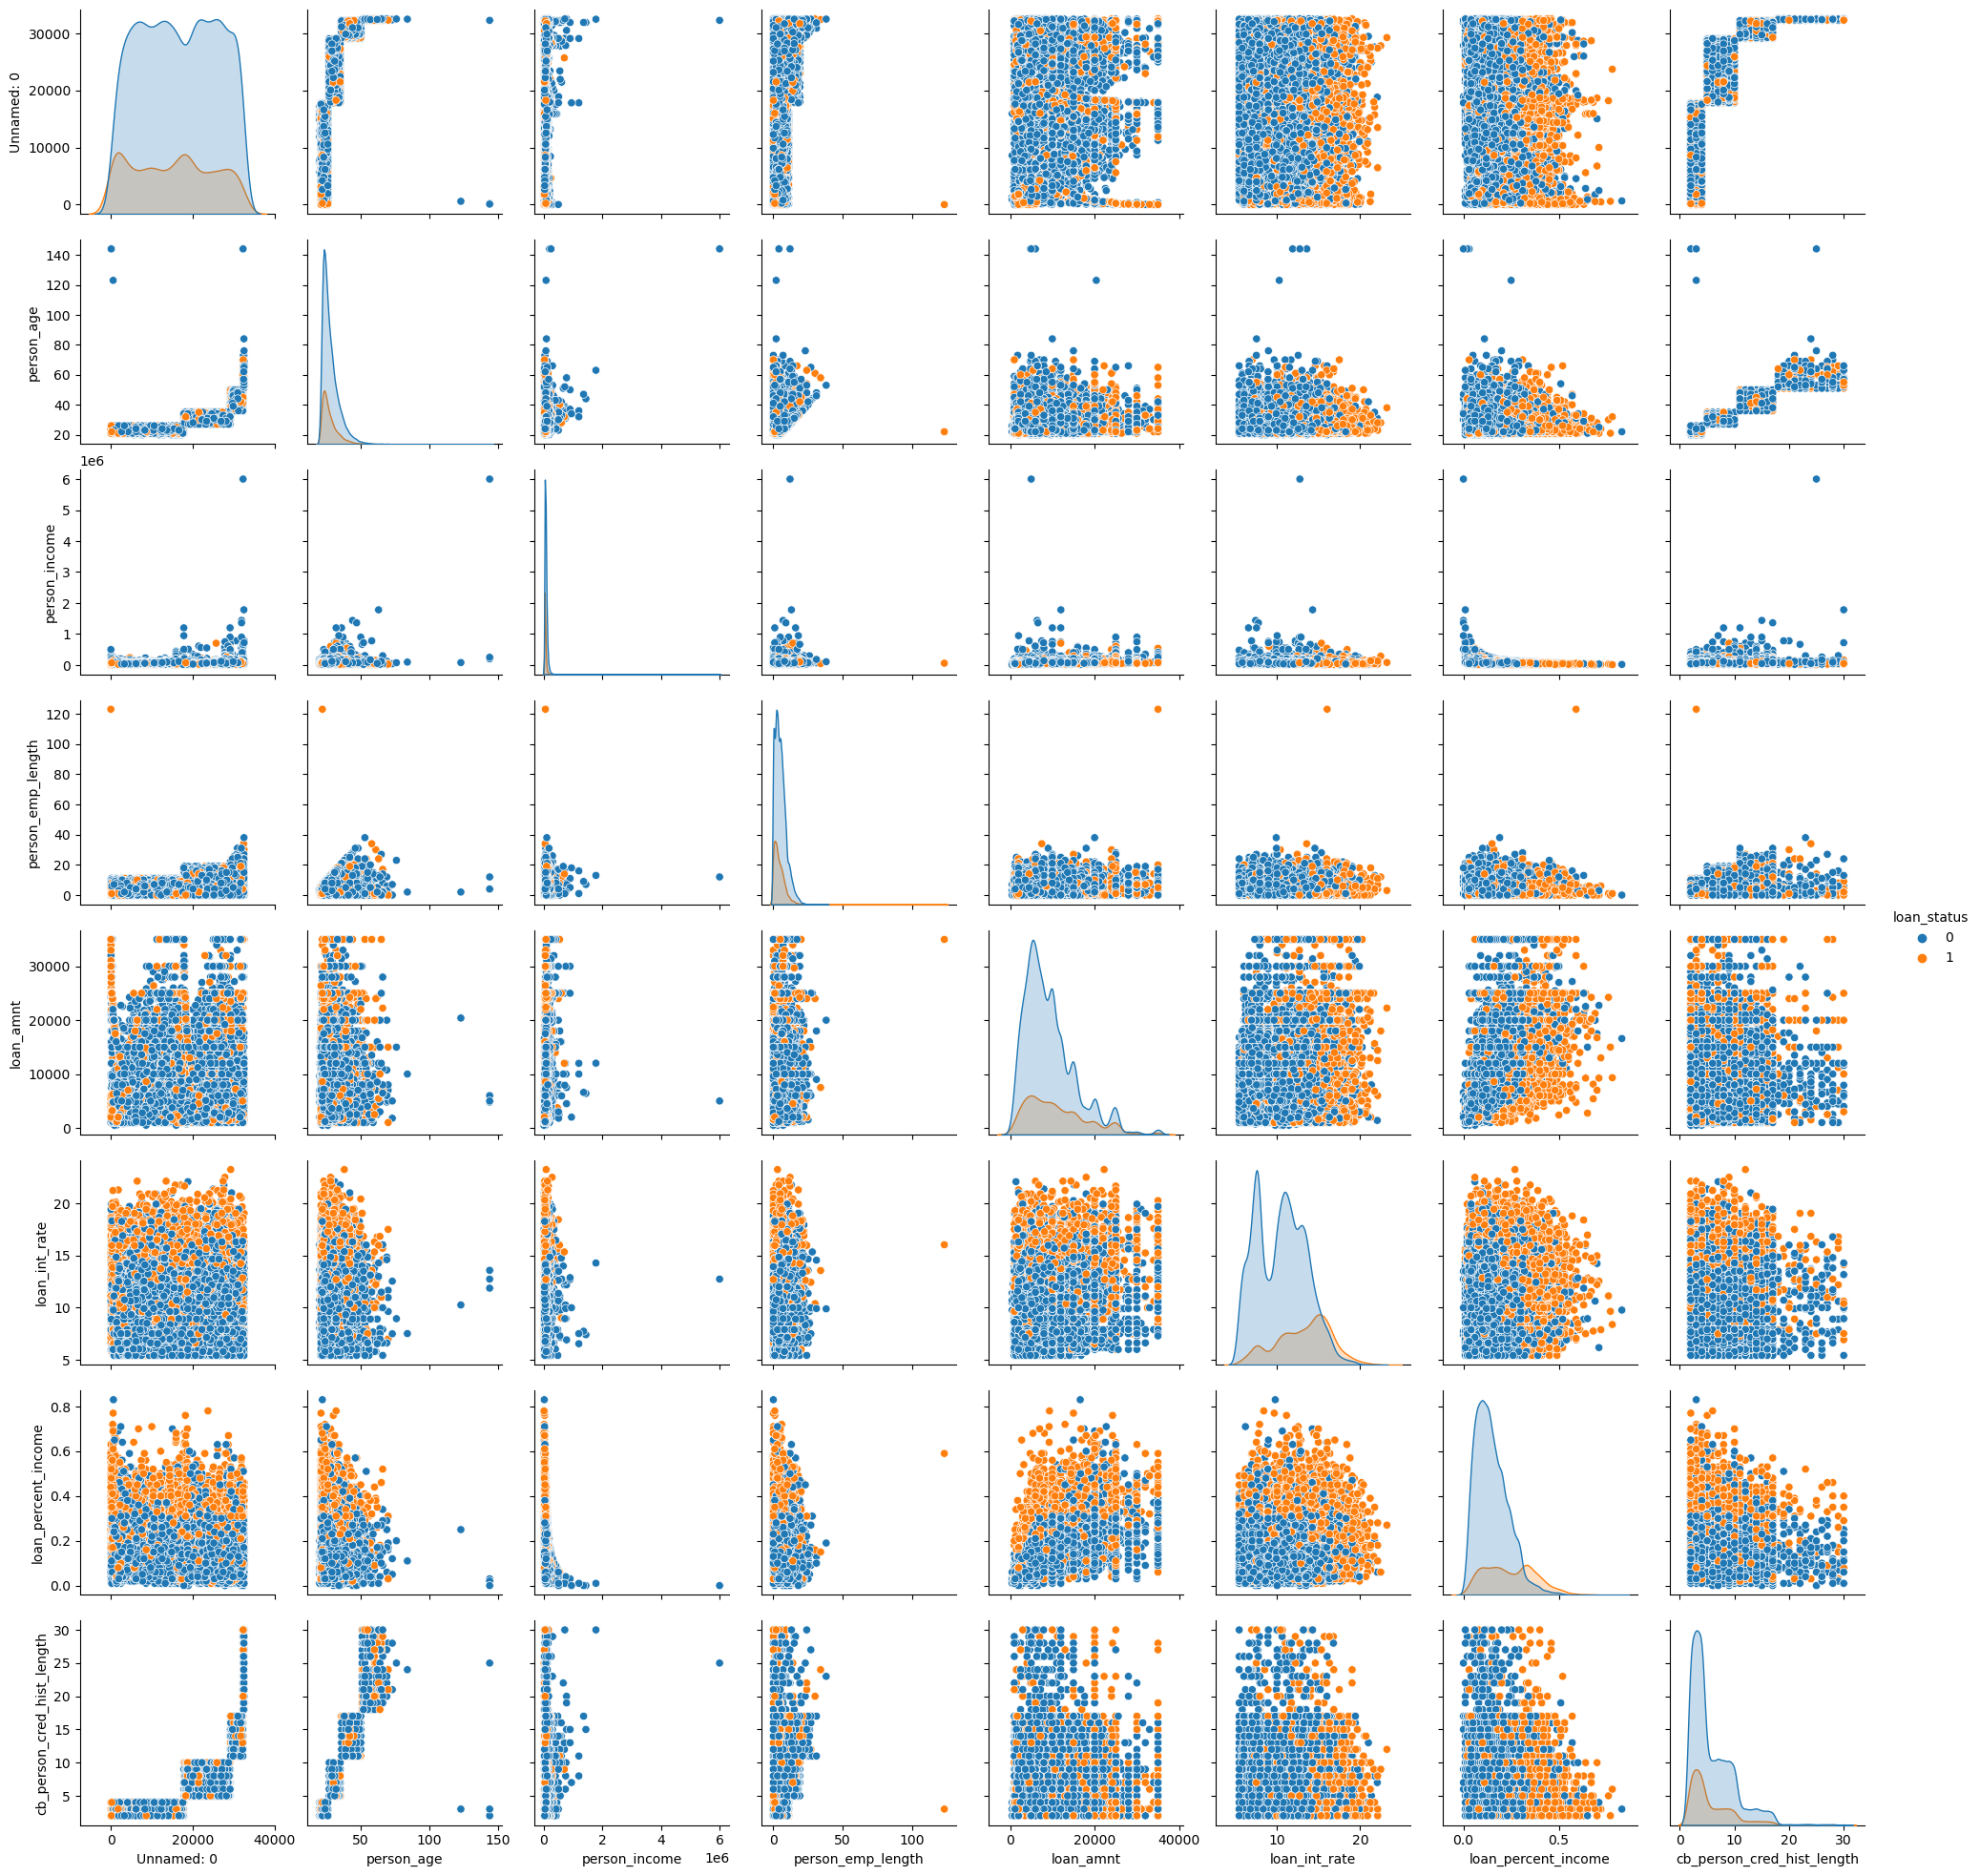

In [160]:
sns.pairplot(df, hue='loan_status')

Some outliers that look far from the rest of the data and probably aren't super valuable:

<ul>
<li> age > 100
<li> income > 2000000
<li> emp length > 50
</ul>

In [161]:
# First, drop Unnamed: 0, looks like some sort of ID

df = df.drop(columns='Unnamed: 0')

In [162]:
# Remove Outliers
df_ = df[df['person_age'] < 100]
df_ = df_[df_['person_income'] < 2000000]
df_ = df_[df_['person_emp_length'] <= 50]

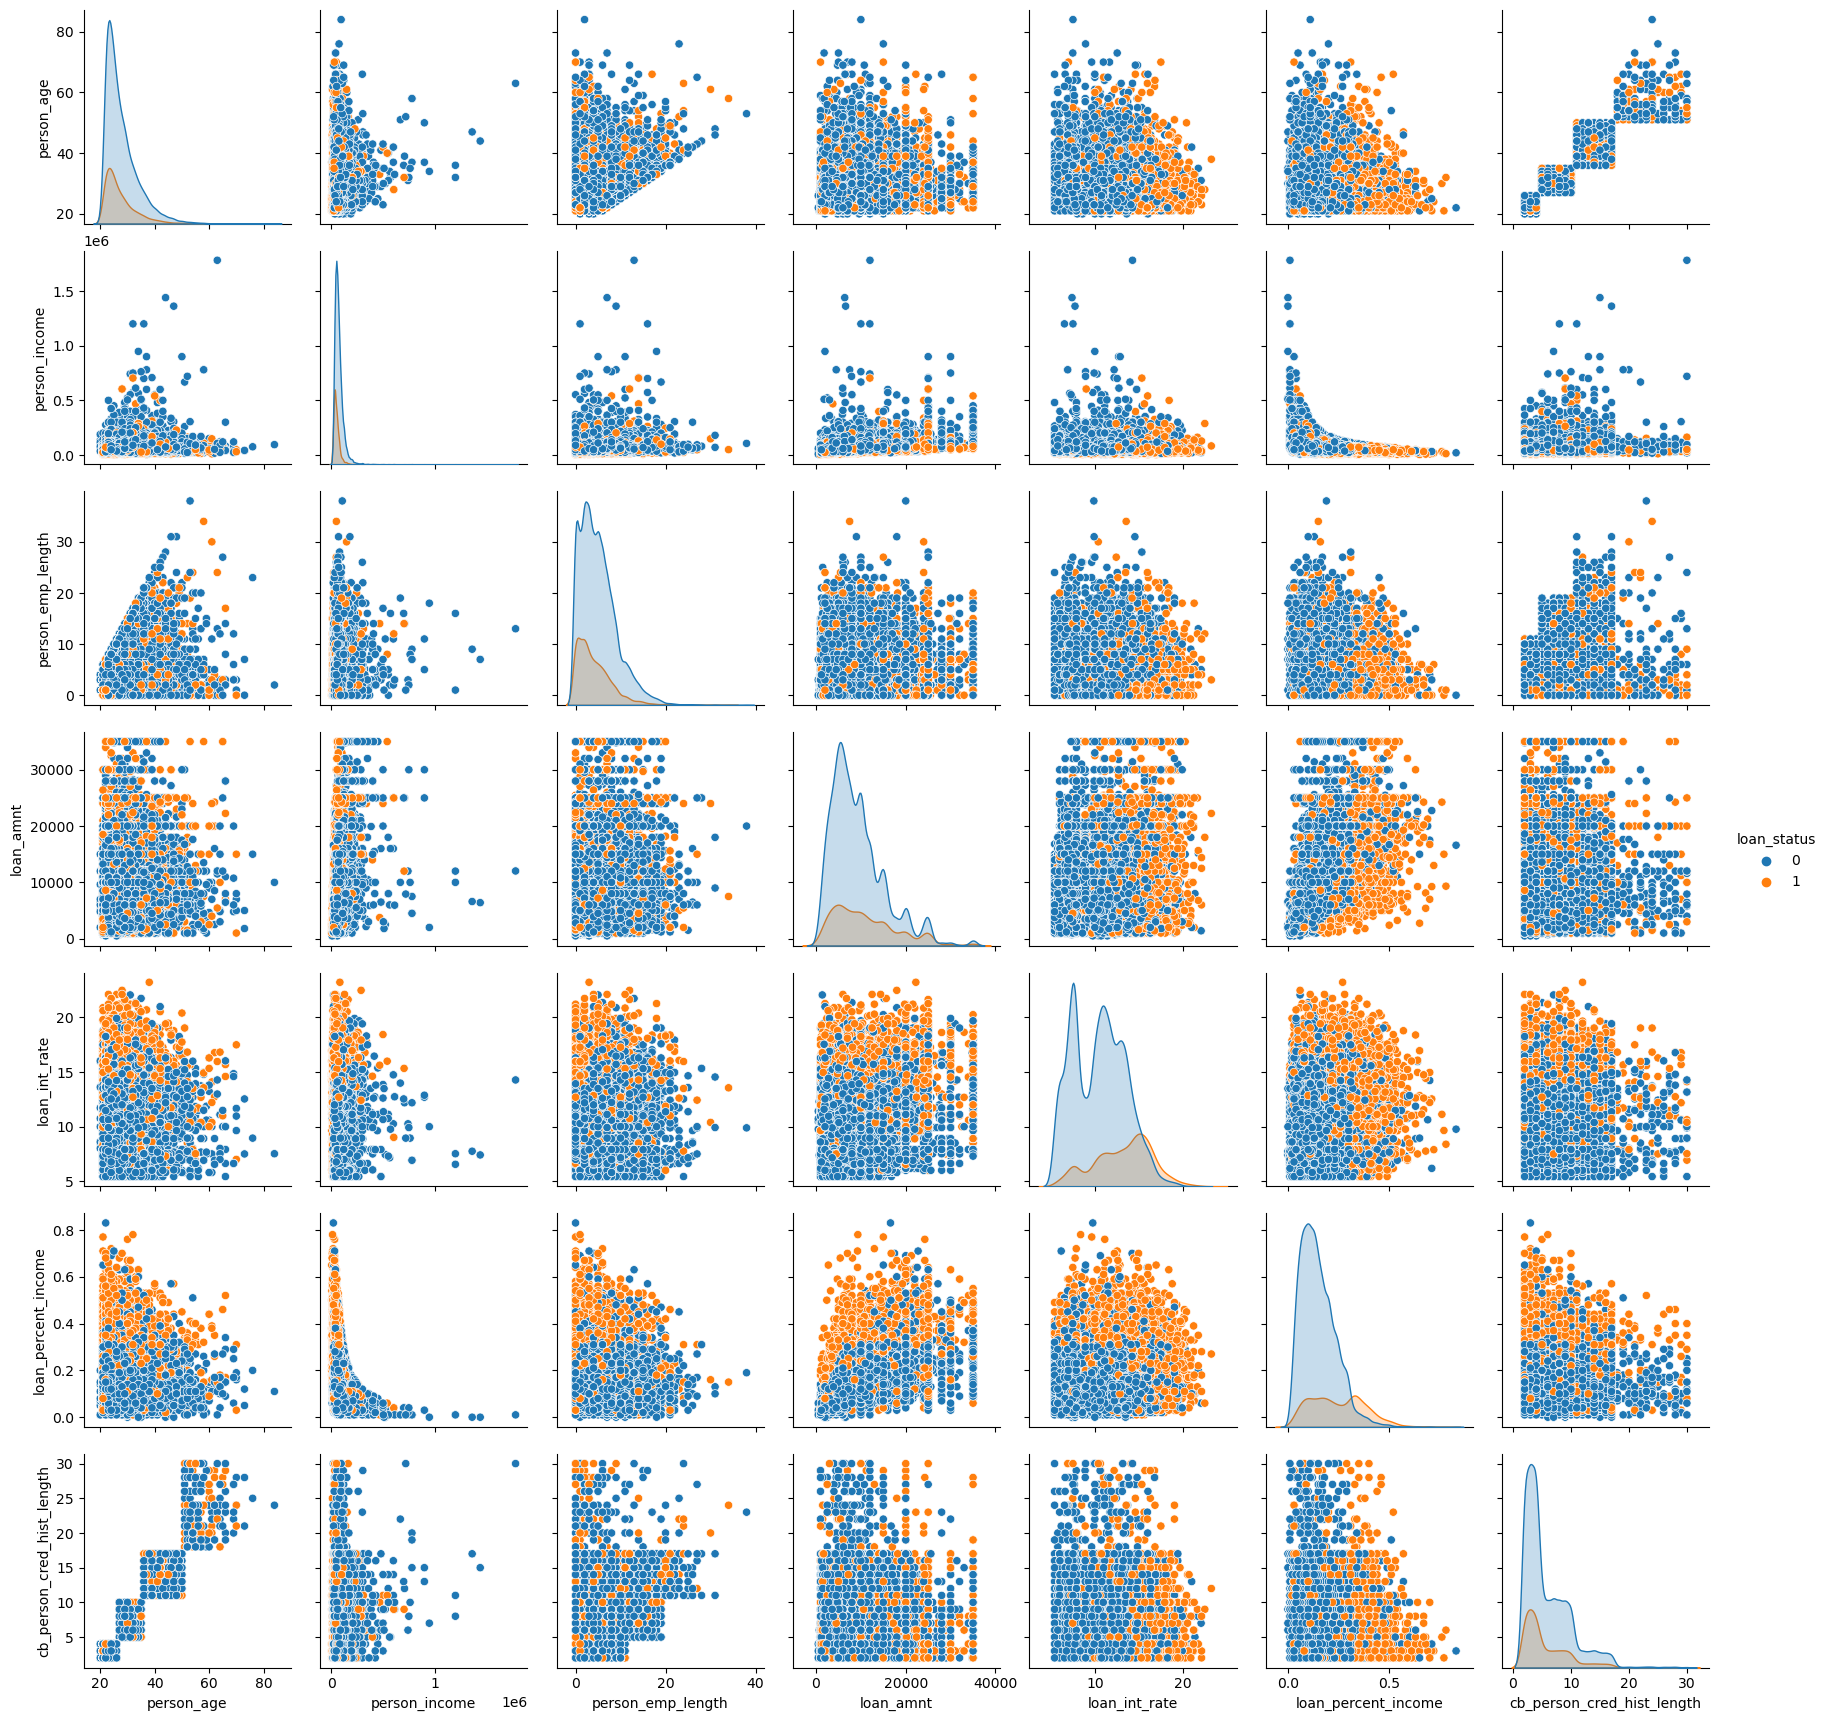

In [163]:
sns.pairplot(df_, hue='loan_status')

By visualizing the distributions, it looks like loan interest rate is a good indicator of good and bad credit risk. At roughly around 15% interest rates, more of the data appears to be have loan_status = 1. However, it is likely that higher interest rates are the result of having bad credit risk. 

We can also see in the pairplots that the majority of points after about loan_percent_income = .3 have loan_status = 1. We can also notice that below around 0.3 loan_percent_income, most of the loans are being paid back. This is likely supported in reality since you're more likely to pay back a loan that doesn't use up a lot of the money you make. There are a few factors to consider here:
<ul>
<li> If you have a higher income, you may not need the loan as much and loans are a smaller percentage of your income.
<li> If you have lower income and you need the loan to survive, it may be necessary to have a loan to pay for large expenses like housing and vehicles. These larger expenses are probably a higher percentage of your income if you are lower income as well.
</ul> 

Nothing seems to have a super strong relationship. Credit history length seems like it it could be related to age. I think one thing could affect the other, but in my opinion, they are measuring different things that happen to have a correlation. We can also see that loan_percent_income is inversely related to person_income. This makes sense since you need to divide by your income to get a percentage of income.

#### Establish Baseline Accuracy ####

In [164]:
print(df_["loan_status"].value_counts())

0    17969
1     4945
Name: loan_status, dtype: int64


Our model could be 78% accurate if we predict everyone is going to pay back their loans.

#### Prep Data to Create Model ####

In [275]:
df_ = pd.get_dummies(df_, drop_first=True) # One-hot encoding
x = np.array(df_.drop(columns='loan_status'))
y = np.array(df_['loan_status']).reshape(-1, 1)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=.33)

In [276]:
# sampler = SMOTE(n_jobs=-1) 
# sampler = TomekLinks(sampling_strategy='not minority', n_jobs=-1) 
# sampler = SMOTETomek(n_jobs=-1)
sampler = ADASYN(n_jobs=-1)
# sampler = SVMSMOTE(n_jobs=-1)

xTrain_samp, yTrain_samp = sampler.fit_resample(xTrain, yTrain)
print('Resampled dataset shape %s' % Counter(yTrain_samp))


Resampled dataset shape Counter({0: 12032, 1: 11662})


The data is relatively imbalanced since 78% of the people in the data are likely to pay back their loans. Tried using ADASYN, SVMSMOTE, SMOTE, TomekLinks, SMOTETOMEK to adjust for the imbalance. They all had fairly similar results in the models I tested them in. I decided against using SMOTETomek since it could potentially remove useful, real data points along the boundary after its been oversampled and there is no minority sample. 

In the end, I decided to use ADASYN since it may take into account the skewed distributions of some of the features

In [277]:
# Normalize Data
scaler = MinMaxScaler()
# scaler = StandardScaler()

xTrain_scaled = scaler.fit_transform(xTrain_samp)
xTest_ = scaler.transform(xTest)


Decided to use a Scaler since we are dealing with things of different scales (interest rates, percentages of income, loan amount, etc). Used MinMaxScaler but also tried StandardScaler. Both were pretty similar. In the end, I stuck with MinMaxScaler since the features didn't look exactly Normal. However, StandardScaler may have been fine to use too since the features could be interpreted as having a normal-ish distribution. I personally decided they didn't look that Normal.

#### Create and Test Model ####

Logistic Regression

F1: 0.6328981723237597
Acc: 0.8140703517587939


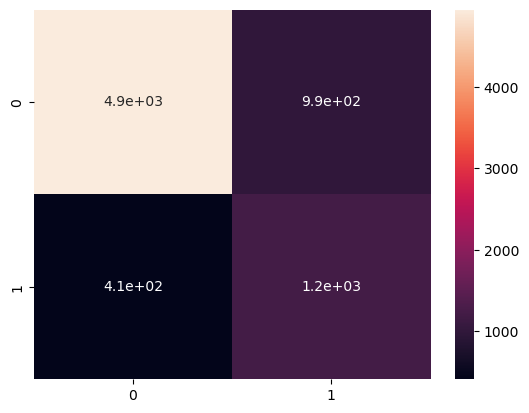

In [278]:
model1 = LogisticRegression(max_iter=1000).fit(xTrain_scaled, yTrain_samp.ravel())
predictions = model1.predict(xTest_)
classifications = binarize(np.array(predictions).reshape(-1, 1), threshold=0.5)

matrix = confusion_matrix(yTest, classifications)
sns.heatmap(matrix, annot=True)

print("F1:",f1_score(yTest, classifications))
print("Acc:", accuracy_score(yTest, classifications))

Random Forest

F1: 0.8080527594585214
Acc: 0.9268711980957419


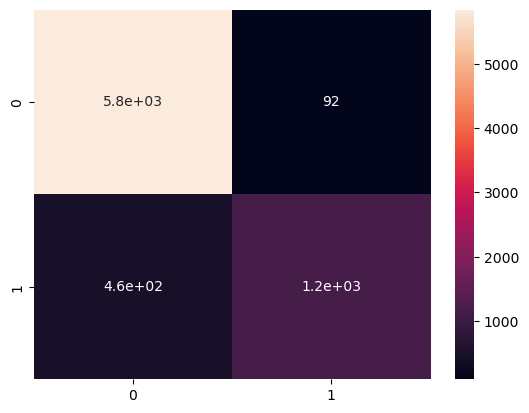

In [279]:
model2 = RandomForestClassifier(n_jobs=-1).fit(xTrain_scaled, yTrain_samp.ravel())
predictions2 = model2.predict(xTest_)
classifications = binarize(np.array(predictions2).reshape(-1, 1), threshold=0.5)

matrix = confusion_matrix(yTest, classifications)
sns.heatmap(matrix, annot=True)

print("F1:",f1_score(yTest, classifications))
print("Acc:", accuracy_score(yTest, classifications))

The random forest scores are way higher. Let's use that. 

Now that we have decided what our model is going to do, let's finalize it and train it using all of the data

#### Final Model ####

In [280]:
# Train using all of data
xTrain_samp2, yTrain_samp2 = sampler.fit_resample(x, y) 
print('Resampled dataset shape %s' % Counter(yTrain_samp2))

# Our final model
model = make_pipeline(MinMaxScaler(), RandomForestClassifier(n_jobs=-1))
model.fit(xTrain_samp2, yTrain_samp2.ravel()) # Fit model to scaled data
preds = model.predict(xTest) # Predict scaled data
classifications = binarize(np.array(preds).reshape(-1, 1), threshold=0.5) # Labels 1 or 0

# Accuracy test to double check nothing went wrong
matrix = confusion_matrix(yTest, classifications)
sns.heatmap(matrix, annot=True)

print("F1:",f1_score(yTest, classifications))


Resampled dataset shape Counter({0: 17969, 1: 17231})
F1: 1.0


High F1 score likely because the data it is tested against is also in the training data

### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 

<b>Note:</b> you could test and make sure that things are working OK here by taking part of your dataset, saving it in a separate CSV, and running it through here as a piece of test data. The accuracy results would be useless, but you'd confirm that the model works properly. 

F1: 1.0


<AxesSubplot:>

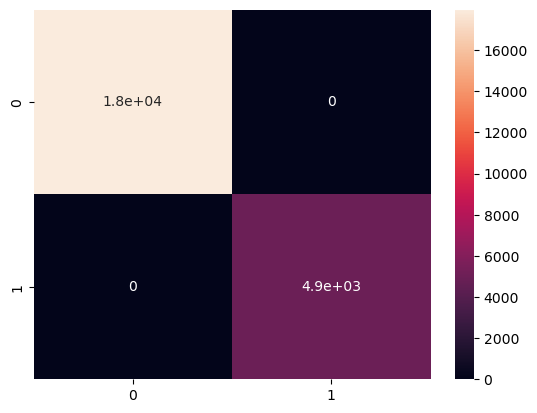

In [273]:
d_test = pd.read_csv("train.csv")

######################
# Insert whatever you need to do to prep the data here. 
# It might be nothing if you have a big pipeline. 
# Ensure that at the end your data is in two arrays - xtest and ytest

# Drop nulls
d_test = d_test.dropna()

# Drop Unnamed: 0
d_test = d_test.drop(columns='Unnamed: 0')

# Make features categorical
d_test[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']] = d_test[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']].astype('category')

# One-hot
df_ = pd.get_dummies(df_, drop_first=True)

# Split data
xtest = np.array(df_.drop(columns='loan_status'))
ytest = np.array(df_['loan_status']).reshape(-1, 1)

# Ensure the name of your final model is "model"

predictions = model.predict(xtest)
prediction_labels = binarize(np.array(predictions).reshape(-1, 1), threshold=0.5)

# Each should contain the ENTIRE x or y dataset in the test data. 
#
# This part should be reusable - any dataset in this format should just run
# and generate predictions and accuracy stats. 
# Please DO NOT do any train-test splitting here. 
#######################

# This should work once you're done, as is. 
# uncomment the stuff below when ready to run.
print("F1:",f1_score(ytest, prediction_labels))
conf_matrix = confusion_matrix(ytest, prediction_labels)
sns.heatmap(conf_matrix, annot=True)